# About this notebook: 
This jupyter notebook is used to analyze the association between functional model factors and the drug sensitivity (IC50 values).  The  functional model factors are from the result of Example3_generate_FM_matrix.ipynb. 

#### Load libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
import Drug_response
import Query

import rpy2
from rpy2.robjects.packages import importr
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
base = importr('base')
CC = importr('ConsensusClusterPlus')
pheatmap = importr('pheatmap')
bezier = importr('bezier')
ROOT_DIR = os.path.abspath("../")

In [2]:
para = {
    'output_dir': ROOT_DIR+"/Sample_output/Example3/",
    'input_dir': ROOT_DIR+"/Sample_input/Example3/",
    'output_fmf_file':ROOT_DIR+"/Sample_output/Example3/" +"matrix_factor_brca_gdsc.csv",
    'Label_UP': True,
    'Label_DOWN':True,
    'Label_ssGSEA': True,
    'Label_TF':True,
    'isAbsoluteValues':False,
    'sele_modules': ['Translation',
        'Nucleotide metabolism',
        'Signal transduction',
        'Amino acid metabolism',
        'Folding sorting and degradation',
         'Replication and repair',
         'Carbohydrate metabolism',
         'Membrane transport',
         'Cellular community - eukaryotes',
         'Lipid metabolism',
         'Metabolism of other amino acids',
         'Transcription',
         'Xenobiotics biodegradation and metabolism',
         'Signaling molecules and interaction',
         'Energy metabolism',
         'Transport and catabolism',
         'Glycan biosynthesis and metabolism',
         'Metabolism of cofactors and vitamins',
         'Cell motility',
         'Cell cycle', 
         'Apoptosis', 
         'Cellular senescence', 
         'p53 signaling pathway']
}

#### IC50 values, AUC values and the drug annotation information are derived from the GDSC project (https://dx.doi.org/10.1016%2Fj.cell.2016.06.017, https://www.cancerrxgene.org/) . 

In [3]:
## Read the FM-matrix
matrix_factor = pd.read_csv(para['output_dir'] +"/matrix_factor_brca_gdsc.csv", index_col= "Unnamed: 0")
## Read the IC50, AUC and drug annotation tables. Data from GDSC project. 
Drug_IC50 = pd.read_csv(para['input_dir'] +"Drug_IC50_matrix.csv", index_col= "Unnamed: 0") #This includes all drugs and all cell lines
Drug_AUC = pd.read_csv(para['input_dir'] +"Drug_AUC_matrix.csv", index_col= "Unnamed: 0")
DrugInformation = pd.read_csv(para['input_dir'] + '/Drug_annotation.csv', index_col= "Unnamed: 0")

##### Select IC50 valuse for breast cancer cell lines

In [4]:
output_dir = para['output_dir']
BRCA_cellLine = list(matrix_factor.index.values)

cell_lines_Brca = list(set(Drug_IC50.columns.tolist()).intersection(set(Drug_response.convert(BRCA_cellLine))))
Drug_IC50[Drug_response.convert(cell_lines_Brca)]
Drug_IC50_new = Drug_IC50[Drug_response.convert(cell_lines_Brca)]

effect_drugs = (Drug_response.effective_drugs(Drug_IC50[Drug_response.convert(cell_lines_Brca)], 
                                              thereshold_percentage= 0.1, 
                                              thereshold_sensitivity = -1, 
                                              measurements = 24)) #0.1 means 10 percent of samples show log(IC50) values smaller than -1
drug_matrix = Drug_IC50.loc[effect_drugs]
drug_matrix_brca = drug_matrix[Drug_response.convert(cell_lines_Brca)]
drug_matrix_new = drug_matrix_brca[Drug_response.convert(list(matrix_factor.index.values))]


##### measure the correlation between the FM-factors and the IC50s

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
../Script/Drug_response.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  frameon=None, metadata=None)
../Script/Drug_r

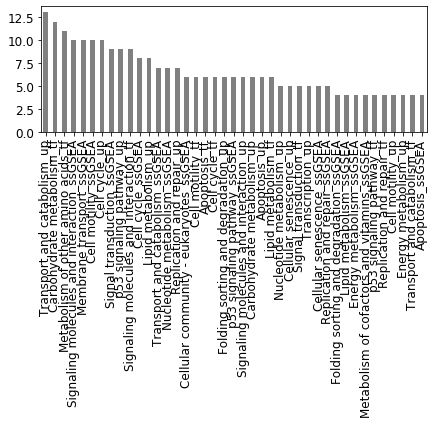

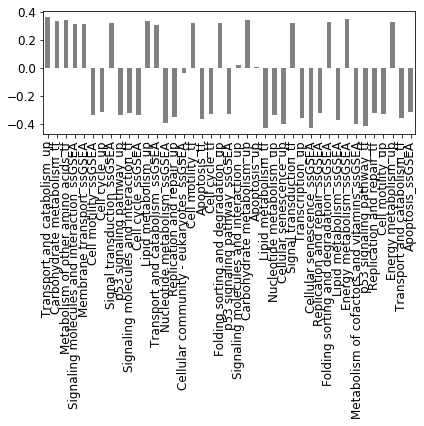

In [5]:
pd_cor,pd_pVal = Drug_response.correlation_analysis(matrix_factor, drug_matrix_new, min_IC50 = -1)
sig_pd = Drug_response.plot_pval(pd_pVal, pd_cor,3,output_dir)


In [6]:
cor_matrix_simp, cor_matrix_sig_simp, cor_matrix_sig = Drug_response.get_sig_matrix(pd_pVal, pd_cor, sig_pd.index.values.tolist())

In [7]:
DrugInformation['new_id'] = DrugInformation['Drug_name'] +':'+ DrugInformation['Drug_Targeted_process_or_pathway']


In [8]:
def rename_drug(cor_matrix_sig_simp, DrugInformation):
    name_list = []
    id_list = cor_matrix_sig_simp.index.tolist()
    for idx in id_list:
        name = (DrugInformation.loc[DrugInformation['Drug_Identifier'] == (idx)]['Drug_name'].values).tolist()[0]
        name_list.append(name)
    
    cor_matrix_sig_simp.index = name_list
    return(cor_matrix_sig_simp)


In [9]:
cor_matrix_sig_simp_new = rename_drug(cor_matrix_sig_simp, DrugInformation)
cor_matrix_simp_new = rename_drug(cor_matrix_simp, DrugInformation)

In [10]:
cor_matrix_simp_new.to_csv(para['output_dir'] + "cor_matrix_simp_new.csv")
cor_matrix_sig_simp_new.to_csv(para['output_dir'] + "cor_matrix_sig_simp_new.csv")

##### Plot the correlation and p-values

In [11]:
matrix_factor_selected_sig = cor_matrix_sig_simp[list((set(cor_matrix_sig_simp.columns)) - set(['States']))]
B_sig = matrix_factor_selected_sig.values
nr,nc = B_sig.shape
samples_name = ro.r.c(matrix_factor_selected_sig.index.values)
factor_name = ro.r.c(matrix_factor_selected_sig.columns.values)

B_sig = ro.r.matrix(B_sig, nrow=nr, ncol=nc, dimnames = [ matrix_factor_selected_sig.index.values, matrix_factor_selected_sig.columns.values])

anno = DrugInformation.loc[DrugInformation['Drug_name'].isin(matrix_factor_selected_sig.index.to_list())][['Drug_name','Drug_Action','Drug_Targeted_process_or_pathway']]
anno.index = anno['Drug_name']
anno = anno.drop_duplicates()
anno.to_csv(output_dir+"/anotation_drug_sig.csv")


matrix_factor_selected = cor_matrix_simp.loc[list(cor_matrix_sig_simp.index.values),list((set(cor_matrix_sig_simp.columns)) - set(['States']))]
B = matrix_factor_selected.values
nr,nc = B.shape
samples_name = ro.r.c(matrix_factor_selected.index.values)
factor_name = ro.r.c(matrix_factor_selected.columns.values)

Br = ro.r.matrix(B, nrow=nr, ncol=nc, dimnames = [ matrix_factor_selected.index.values, matrix_factor_selected.columns.values])


%load_ext rpy2.ipython

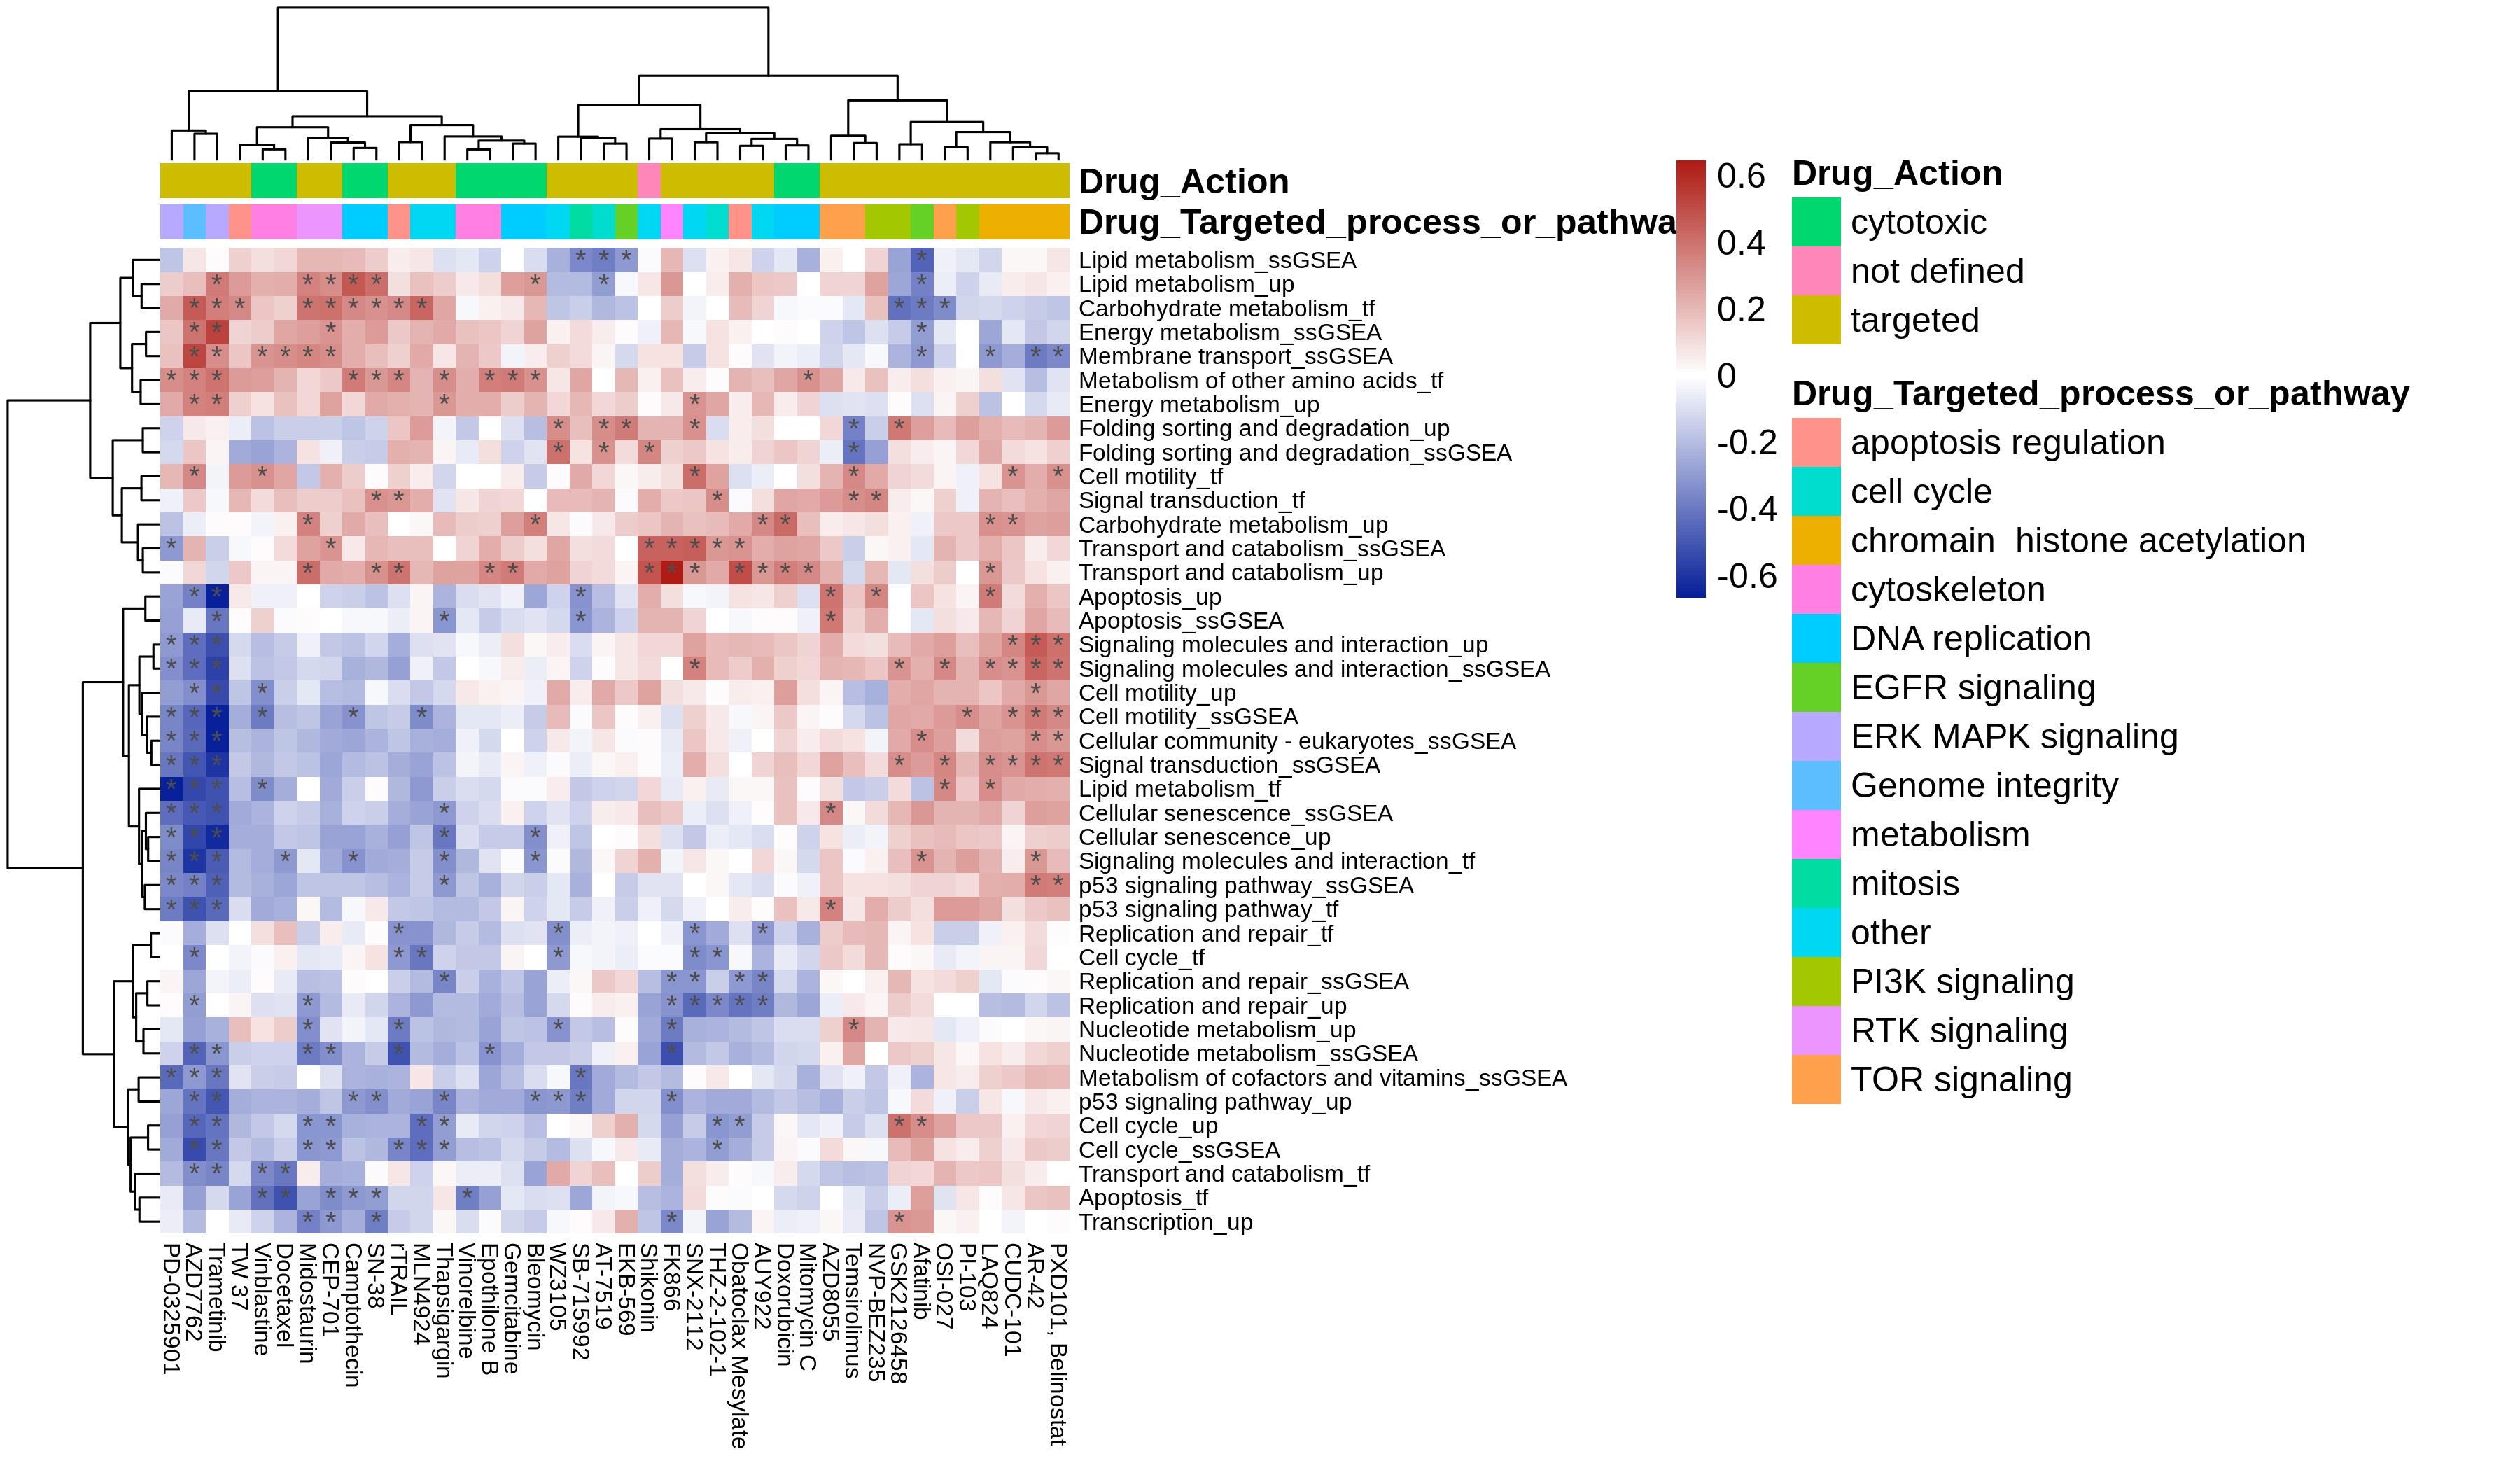

In [12]:
%%R -i Br,B_sig,output_dir  -w 12 -h 7 --units in -r 300

anno = read.csv(file = paste(output_dir,"/anotation_drug_sig.csv", sep = ''))
rownames(anno) = anno[,'Drug_name']
anno = anno[,c('Drug_Targeted_process_or_pathway','Drug_Action')]

#pdf(file = paste(output_dir,"/IC50_FM_correlation.pdf", sep = ''), 12, 7, pointsize = 12)

color_forpheatmap2 = c(c(colorRampPalette(c("#08209a", "white"))(-1 * (round(min(Br)*100))),c(colorRampPalette(c("white","#af1c15"))(round(max(Br)*100))) ))

label <- t(B_sig)
label <- ifelse(label > 0,'*',label)
label <- ifelse(label < 0,'*',label)
label <- ifelse(label == 0,'',label)


pheatmap((t(Br)),
         border_color = "grey",
         border_width = 0.0001,
         cluster_col = TRUE,
         cluster_row = TRUE,
         annotation_col = anno,
         clustering_method = 'ward.D2',
         color = color_forpheatmap2,
         fontsize_row = 8,
         fontsize_col = 8,
         fontsize = 12,
         display_numbers = label)


##### Volcano plot of correlations for a specific FM-factor

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


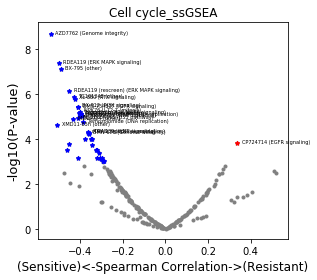

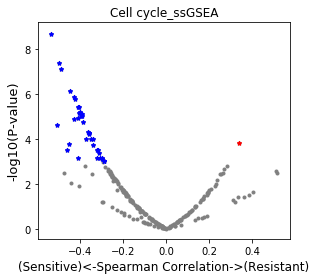

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np, statsmodels.api as sm
import  scipy
from scipy.stats import spearmanr, pearsonr

def regression_simple(drug, factor,Drug_IC50, data_nodes):
    model = LinearRegression()
    rho = 0
    pval = 1
    y = Drug_IC50.loc[drug].values
    x1 = np.array(data_nodes.loc[factor].values)
    x1 = x1[np.isnan(y)==False]
    y = y[np.isnan(y)==False]
    if(len(y) > 10):
        rho, pval = spearmanr(x1,y)
    return(rho, pval)
def convert_toInt(list): 
    res = []
    # Converting integer list to string list 
    for i in list:
        res.append(int(i)) 
    return(res)

def convert(list): 
    res = []
    # Converting integer list to string list 
    for i in list:
        res.append(str(i)) 
    return(res)
def sig_drugs(result_sig_neg_sort):
    idlist = []
    for id in list(result_sig_neg_sort.index.values):
        idlist.append((id))

    result_sig_neg_sort['Drug_Identifier'] = idlist

    Drug_sig = DrugInformation.loc[DrugInformation['Drug_Identifier'].isin(idlist)]
    
    Drug_sig.index = Drug_sig['Drug_Identifier'].tolist()
    
    result_sig_neg_sort.index = result_sig_neg_sort['Drug_Identifier'].tolist()
    
    result = result_sig_neg_sort.merge(Drug_sig, left_on='Drug_Identifier', right_on='Drug_Identifier')
    #result = pd.concat([result_sig_neg_sort, Drug_sig], axis=0, sort=False)
    return(result)


#matrix_factor_selected = matrix_factor[select_modules]
matrix_factor_selected = matrix_factor
drugs = Drug_IC50_new[convert(BRCA_cellLine)].index.values
factors = cor_matrix_sig.columns.values

rho_list = []
pval_list = []

#for i in range(0,cor_matrix_sig.shape[1]):
#i = 3
#i = 0
i = 10
factor = cor_matrix_sig.columns.values[i]
#factor = 'p53 signaling pathway_ssGSEA'
for drug in drugs:
    rho,pval = regression_simple(drug, factor, Drug_IC50_new[convert(BRCA_cellLine)],matrix_factor_selected.transpose())
    rho_list.append(rho)
    pval_list.append(pval)

result_pd = pd.DataFrame({"rho":rho_list, "pval":pval_list})
result_pd.index = drugs
result_pd['pval'] = -1 * np.log(result_pd['pval'])

result_sig = result_pd.loc[result_pd['pval'] > -1 * np.log(0.05)]
result_sig_neg = result_sig.loc[result_sig['rho'] < 0]
result_sig_pos = result_sig.loc[result_sig['rho'] > 0]
result_sig_neg_sort = result_sig_neg.sort_values(by = 'pval', ascending=False)
result_sig_pos_sort = result_sig_pos.sort_values(by = 'pval', ascending=False)

plt.figure(figsize=(4.5,4))
plt.xlabel("(Sensitive)<-Spearman Correlation->(Resistant)", fontsize =  12)
plt.ylabel("-log10(P-value)", fontsize =  13)
plt.scatter(result_pd['rho'],result_pd['pval'],c='grey', marker = ".")
plt.scatter(result_sig_neg['rho'],result_sig_neg['pval'],c='b',marker = "*", s = 18)
plt.scatter(result_sig_pos['rho'],result_sig_pos['pval'],c='r',marker = "*", s = 18)  
plt.title(factor)
plt.tight_layout()

count = 0

for index in range(result_sig_pos_sort.shape[0]):
    count = count + 1
    x = result_sig_pos_sort.iloc[index]["rho"]+0.02
    y = (pd.to_numeric(result_sig_pos_sort.iloc[index]["pval"])) 
    Value = list(result_sig_pos_sort.index)[index]
    label = DrugInformation[DrugInformation['Drug_Identifier'] == (Value)]['Drug_name'].values[0] + ' (' + DrugInformation[DrugInformation['Drug_Identifier'] == (Value)]['Drug_Targeted_process_or_pathway'].values[0] + ')'
    plt.text(x,y,label,fontsize=5)
    #x1 = x + 0.015 * len(DrugInformation[DrugInformation['Drug_Identifier'] == str(Value)]['Drug_name'].values[0])
    #plt.text(x1,y,'(' + DrugInformation[DrugInformation['Drug_Identifier'] == str(Value)]['Drug_Targeted_process_or_pathway'].values[0] + ')',fontsize=3, color = 'r')
    if count > 20:
        break

count = 0

for index in range(result_sig_neg_sort.shape[0]):
    count = count + 1
    x = result_sig_neg_sort.iloc[index]["rho"]+0.02
    y = (pd.to_numeric(result_sig_neg_sort.iloc[index]["pval"])) 
    Value = list(result_sig_neg_sort.index)[index]
    plt.text(x,y,DrugInformation[DrugInformation['Drug_Identifier'] == (Value)]['Drug_name'].values[0] + ' (' + DrugInformation[DrugInformation['Drug_Identifier'] == (Value)]['Drug_Targeted_process_or_pathway'].values[0] + ')',fontsize=5)
    if count > 20:
        break
plt.tight_layout()        
plt.savefig(output_dir + '/vocano_'+factor+".pdf", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format="pdf",
        transparent=True, bbox_inches=None, pad_inches=0.2,
        frameon=None, metadata=None)

plt.figure(figsize=(4.5,4))
plt.xlabel("(Sensitive)<-Spearman Correlation->(Resistant)", fontsize =  12)
plt.ylabel("-log10(P-value)", fontsize =  13)
plt.scatter(result_pd['rho'],result_pd['pval'],c='grey', marker = ".")
plt.scatter(result_sig_neg['rho'],result_sig_neg['pval'],c='b',marker = "*", s = 18)
plt.scatter(result_sig_pos['rho'],result_sig_pos['pval'],c='r',marker = "*", s = 18)  
plt.title(factor)
plt.tight_layout()

count = 0

for index in range(result_sig_pos_sort.shape[0]):
    count = count + 1
    x = result_sig_pos_sort.iloc[index]["rho"]+0.02
    y = (pd.to_numeric(result_sig_pos_sort.iloc[index]["pval"])) 
    Value = list(result_sig_pos_sort.index)[index]
    if count > 20:
        break

count = 0

for index in range(result_sig_neg_sort.shape[0]):
    count = count + 1
    x = result_sig_neg_sort.iloc[index]["rho"]+0.02
    y = (pd.to_numeric(result_sig_neg_sort.iloc[index]["pval"])) 
    Value = list(result_sig_neg_sort.index)[index]
    if count > 20:
        break
plt.tight_layout()        
plt.savefig(output_dir + '/vocano_'+factor+"_noLabel.pdf", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format="pdf",
        transparent=True, bbox_inches=None, pad_inches=0.2,
        frameon=None, metadata=None)


result_neg = sig_drugs(result_sig_neg_sort)
result_pos = sig_drugs(result_sig_pos_sort)

In [14]:
result_neg.sort_values(['pval'],ascending = False)

,rho,pval,Drug_Identifier,Drug_name,Drug_Action,Drug_Targeted_process_or_pathway,Drug_Putative_Target,new_id
0,-0.536575,8.658823,1022,AZD7762,targeted,Genome integrity,"CHEK1, CHEK2",AZD7762:Genome integrity
1,-0.500302,7.362592,1014,RDEA119,targeted,ERK MAPK signaling,"MAP2K1 (MEK1), MAP2K2 (MEK2)",RDEA119:ERK MAPK signaling
2,-0.491392,7.107034,1037,BX-795,targeted,other,"TBK1, PDPK1, IKK, AURKB, AURKC",BX-795:other
3,-0.449894,6.126663,1526,RDEA119 (rescreen),targeted,ERK MAPK signaling,"MAP2K1 (MEK1), MAP2K2 (MEK2)",RDEA119 (rescreen):ERK MAPK signaling
4,-0.429664,5.849014,306,TG101348,targeted,other,JAK2,TG101348:other
5,-0.423451,5.802767,308,XL-880,targeted,RTK signaling,MET,XL-880:RTK signaling
6,-0.408996,5.446547,222,BX-912,targeted,PI3K signaling,PDPK1 (PDK1),BX-912:PI3K signaling
7,-0.408418,5.432616,184,BMS-754807,targeted,IGFR signaling,IGF1R,BMS-754807:IGFR signaling
8,-0.399514,5.221105,257,NPK76-II-72-1,targeted,mitosis,PLK3,NPK76-II-72-1:mitosis
9,-0.404743,5.146583,1372,Trametinib,targeted,ERK MAPK signaling,"MAP2K1 (MEK1), MAP2K2 (MEK2)",Trametinib:ERK MAPK signaling


In [15]:
result_pos.sort_values(['pval'],ascending = False)

,rho,pval,Drug_Identifier,Drug_name,Drug_Action,Drug_Targeted_process_or_pathway,Drug_Putative_Target,new_id
0,0.33765,3.828619,255,CP724714,targeted,EGFR signaling,ERBB2,CP724714:EGFR signaling
